In [101]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


import plotly.graph_objects as go
import plotly.express as px
import spectral
from scipy.io import loadmat
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indian-pines-hyperspectral-dataset/indianpinearray.npy
/kaggle/input/indian-pines-hyperspectral-dataset/IPgt.npy
/kaggle/input/mat-files/Indian_pines.mat
/kaggle/input/mat-files/Indian_pines_gt.mat


# Global Variables

In [4]:

class_labels = {'1':'Alfaalfa','2':'Corn-notill','3':'Corn-mintill','4':'Corn','5':'Grass/pasture','6':'Grass/trees','7':'Grass/pasture-mowed','8':'Hay-windrowed','9':'Oats','10':'Soyabean-notill','11':'Soyabean-mintill','12':'Soyabean-clean','13':'Wheat','14':'Woods','15':'Building-grass-trees-drives','16':'Stone-steel towers'}

# Global Functions

In [52]:
def plot_data(data):
    fig = plt.figure(figsize = (12, 8))
    plt.imshow(data, cmap = 'nipy_spectral')
    plt.colorbar()
    plt.axis('off')
    plt.show()
    
    return None

#.----------------------------------------------------------------------------------------------

def read_HSI():
    X = loadmat('../input/mat-files/Indian_pines.mat')['indian_pines']
    y = loadmat('../input/mat-files/Indian_pines_gt.mat')['indian_pines_gt']
    print(f"X shape:{X.shape}\ny shape: {y.shape}")
    return X,y

#-------------------------------------------------------------------------------------------------
def plot_signature(df):
    plt.figure(figsize=(10, 6))
    
    pixel_no = np.random.randint(df.shape[0])
    
    plt.plot(range(1, 220), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label=f'Class - {df.iloc[pixel_no, -1]}')
    
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    
    plt.show()
    
#----------------------------------------------------------------------------------------------------
def pixel_signature_by_class(df_test, label):
    sns.set_style("whitegrid")

    color_list = ['red', 'blue', 'cyan', 'gray', 'orange']

    fig, ax = plt.subplots(figsize = (10,5))

    df_aux = df_test[df_test['class']==label].reset_index(drop=True)

    df_aux = df_aux.drop(['class'], axis=1)

    pixel_no = []

    for i in range(1,6):

        pixel_no.append(np.random.randint(df_aux.shape[0]))

    pixel_no = list(np.unique(np.array(pixel_no)))


    for i,j in enumerate(pixel_no):

        ax.plot(range(1,220),  df_aux.iloc[pixel_no[i], :-1].values.tolist(), label = f'Pixel NO='+str(j), color = color_list[i], marker = 'o', )
        plt.title('Pixel Signatures for Class: ' + str(label), fontsize=16)
        plt.xlabel('Band Number')
        plt.ylabel('Intensity')

        
        
#---------------------------------------------------------------------------------------------------------
def pca_cum_plot(model, data, fig_size=(12,6)):

  prop_varianza_acum = model.explained_variance_ratio_.cumsum()
  

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fig_size)
  ax.plot(
      np.arange(len(data.columns)) + 1,
      prop_varianza_acum,
      marker = 'o'
  )

  for x, y in zip(np.arange(len(data.columns)) + 1, prop_varianza_acum):
      label = round(y, 2)
      ax.annotate(
          label,
          (x,y),
          textcoords="offset points",
          xytext=(0,10),
          ha='center'
      )
      
  ax.set_ylim(0, 1.1)
  ax.set_xticks(np.arange(model.n_components_) + 1)
  ax.set_title('Cumulative explained variance percentage', fontsize=58)
  ax.set_xlabel('Principal Component', fontsize=46)
  ax.set_ylabel('%Cumulative variance', fontsize=46);

# Load data

## Data Description

Indian Pines dataset is gathered by Airborne Visible/Infrared Imaging Spectrometer (AVIRIS) over the Indian Pines in Northwestern Indiana. The dataset consists of an image that has 200 spectral bands with 145x145 pixels with a spatial resolution of 20 m by pixel.

In [6]:
X, y = read_HSI()

X shape:(145, 145, 220)
y shape: (145, 145)


In [7]:
# Convert data as pd DataFrame from 3-D to 2-D
df = pd.DataFrame(X.reshape(X.shape[0] * X.shape[1], -1))

df.columns = [f'band{i}' for i in range(1, df.shape[-1] + 1)]

df['class'] = y.ravel()


print("Dimension of dataset:", df.shape)

Dimension of dataset: (21025, 221)


# Visualize Spectral Bands:

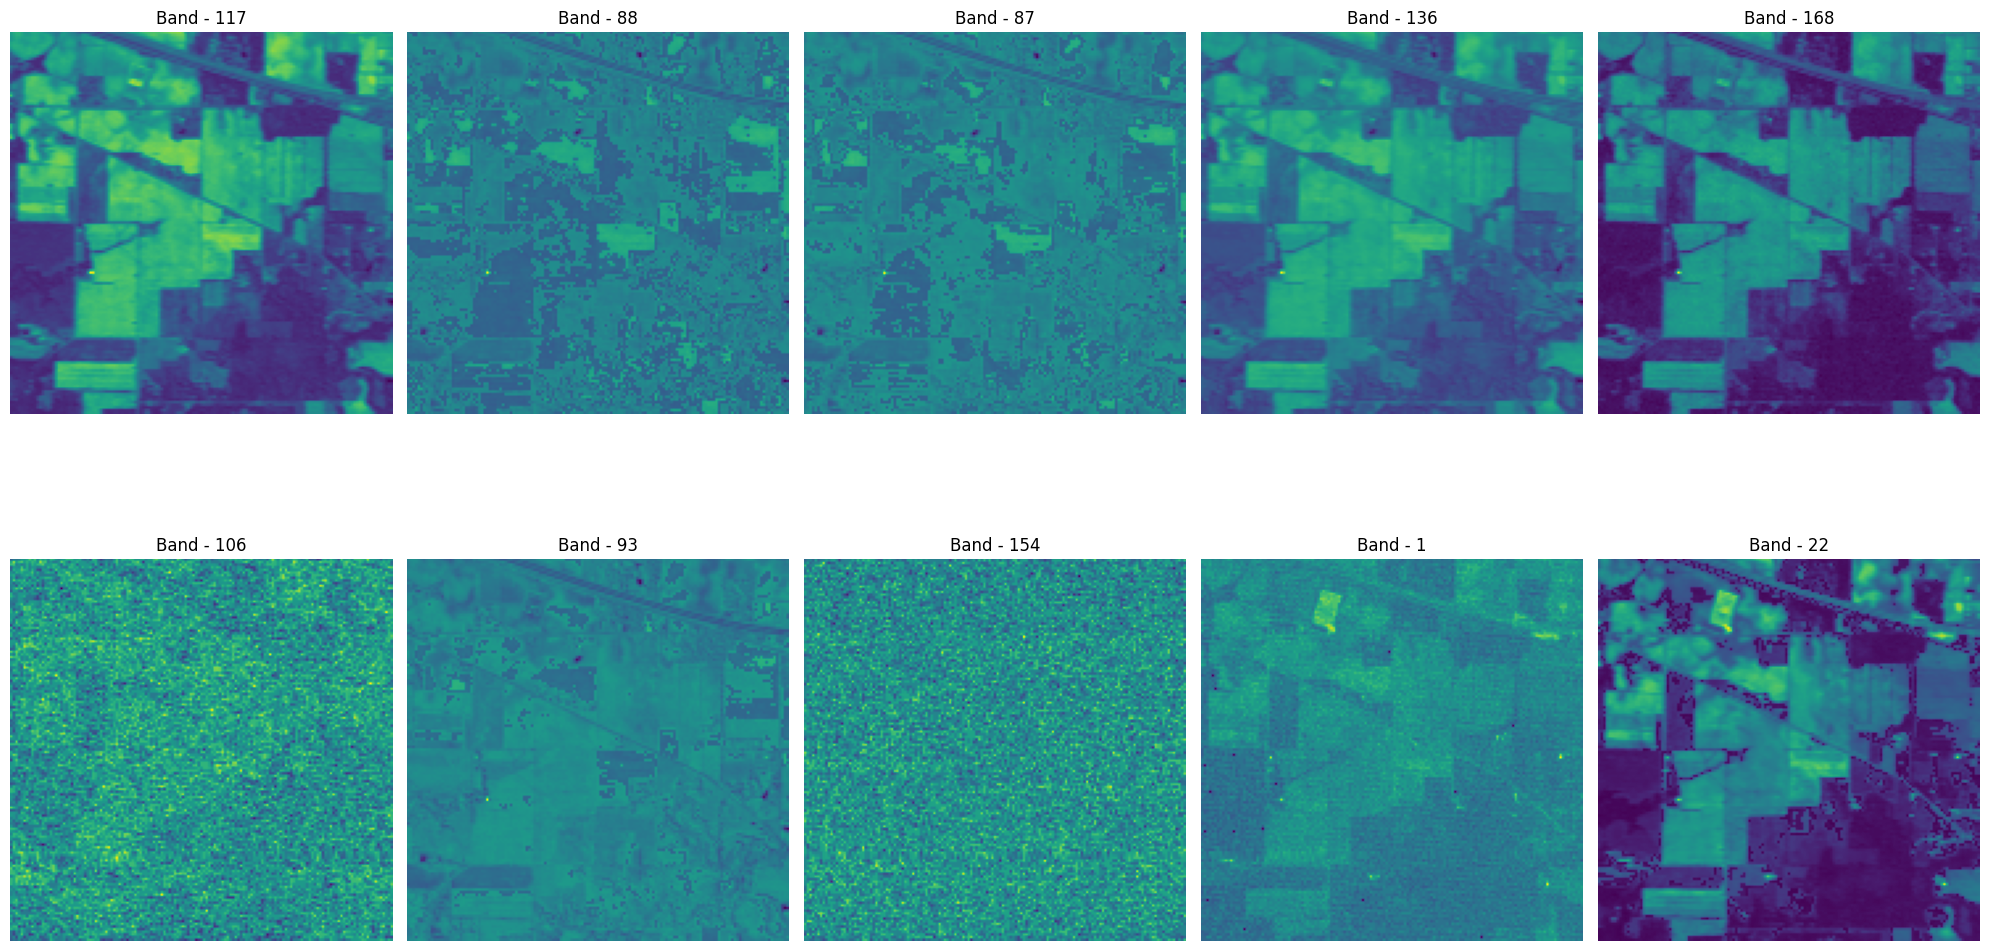

In [8]:
fig = plt.figure(figsize = (20, 12))
ax = fig.subplots(2, 5)

for i in range(2):
    for j in range(5):
        c = np.random.randint(200)
        ax[i][j].imshow(X[:, :, c], cmap='viridis')
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        c += 1

plt.tight_layout()

plt.show()

## Groundtruth

The following image visualizes the ground truth of Indian Pines test site. The ground truth available is designated into sixteen classes and is not all mutually exclusive. This dataset has 16 classes.

NOTE: Black color represents pixels with no information and will be discarded during the classification process.

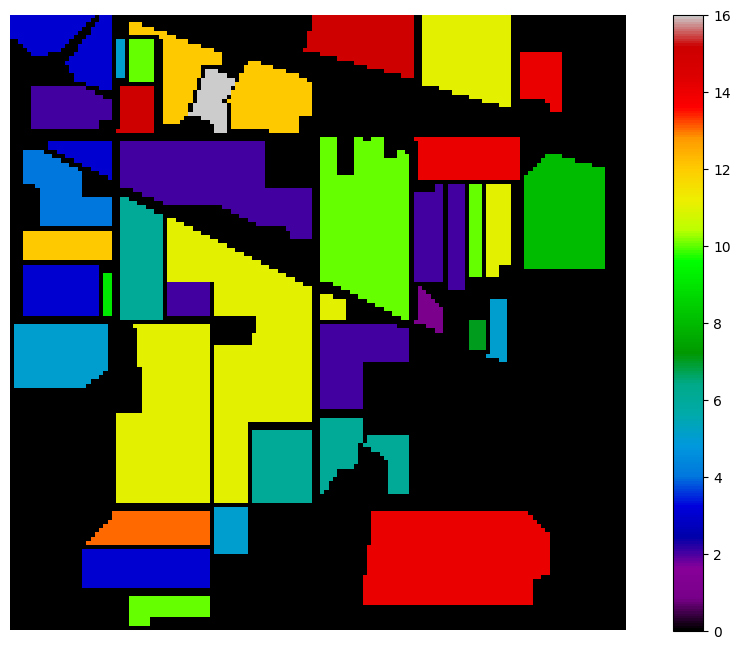

In [9]:
plot_data(y)

## Visualizing Spectral Signature

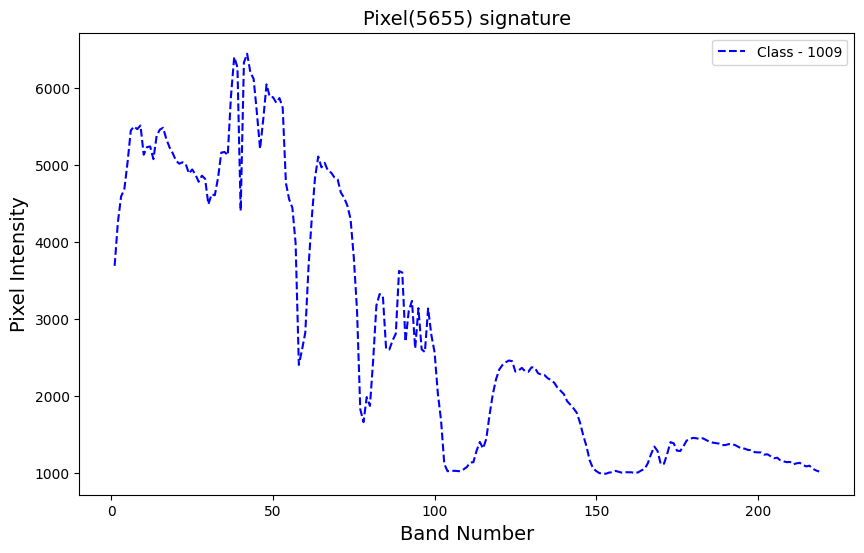

In [10]:
plot_signature(df.loc[:, 'band1':'band220'])

# Data Exploration Analysis

In [11]:
df_pixels = pd.DataFrame(df['class'].value_counts() /df.shape[0]).rename(columns={'count':'pct_pixels'}).reset_index()


fig = px.bar(df_pixels, x='class', y='pct_pixels', title='Distribution of the classes by Pixels')

fig.update_layout(
    plot_bgcolor='white'
)

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title='Class'
)

fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title='%Pixels'
)

fig.show()

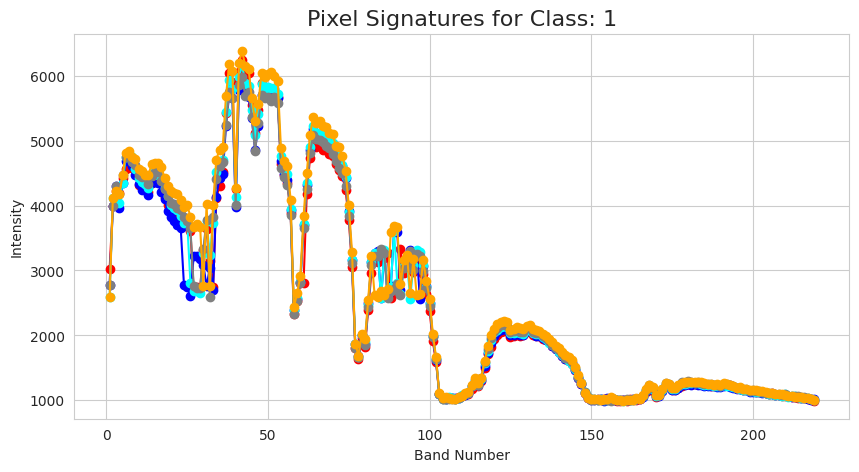

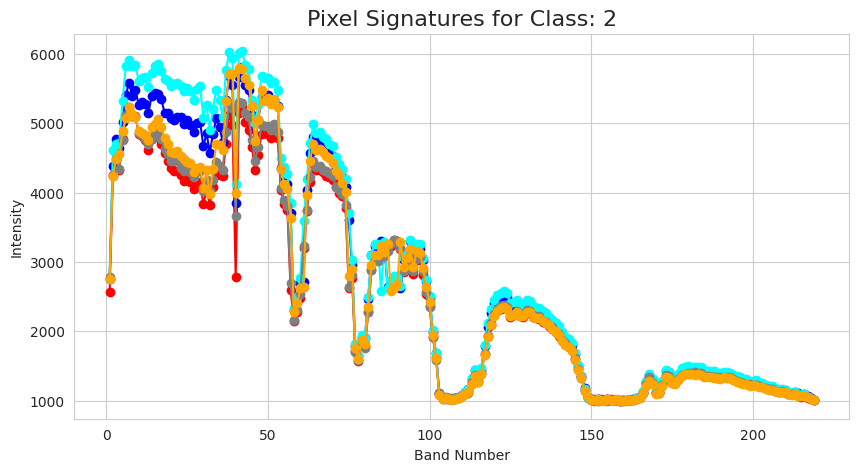

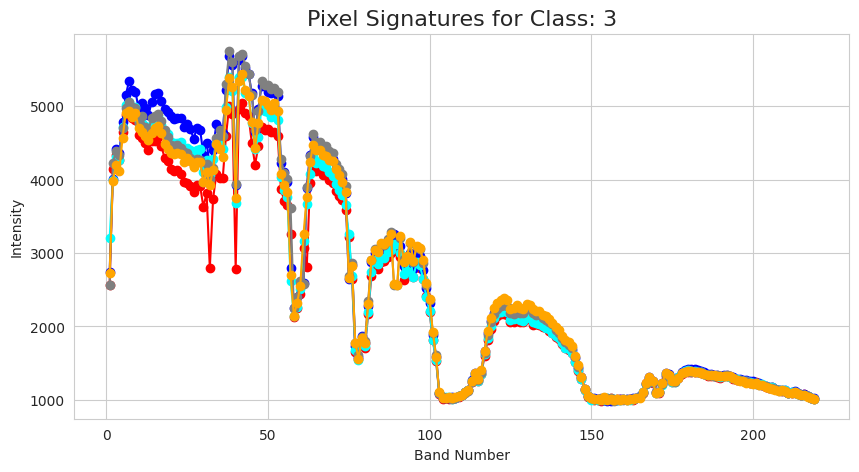

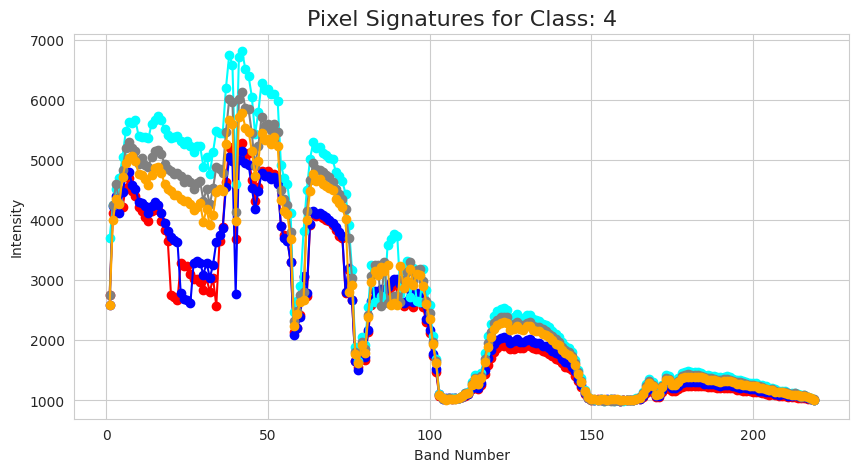

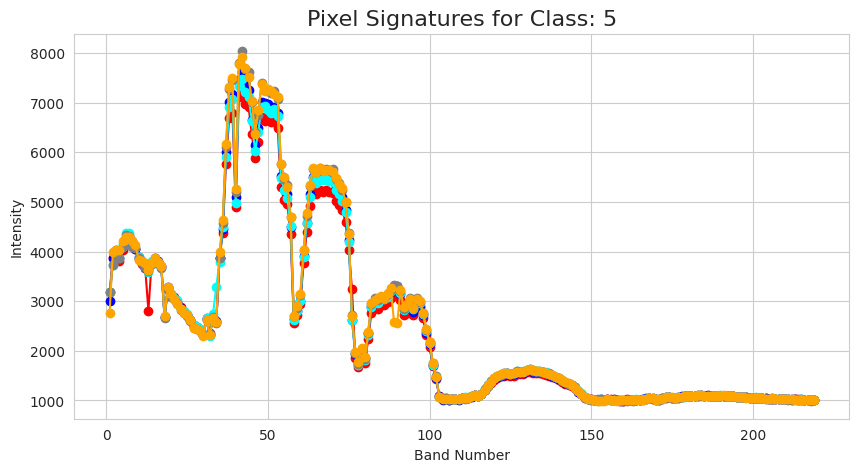

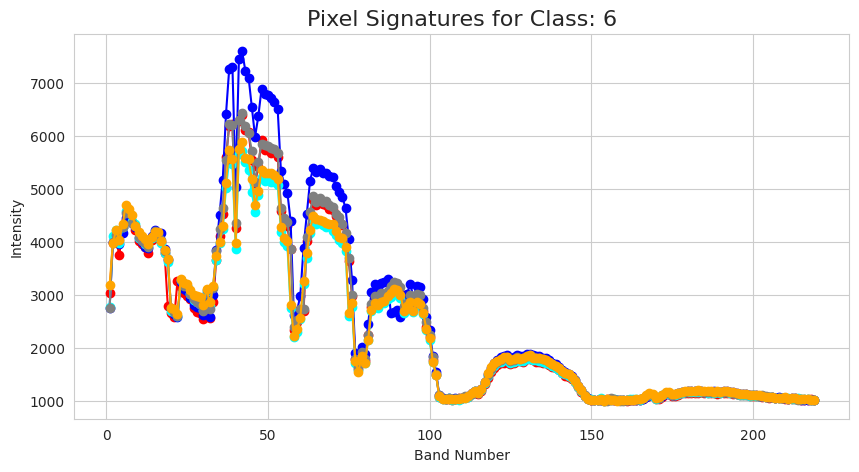

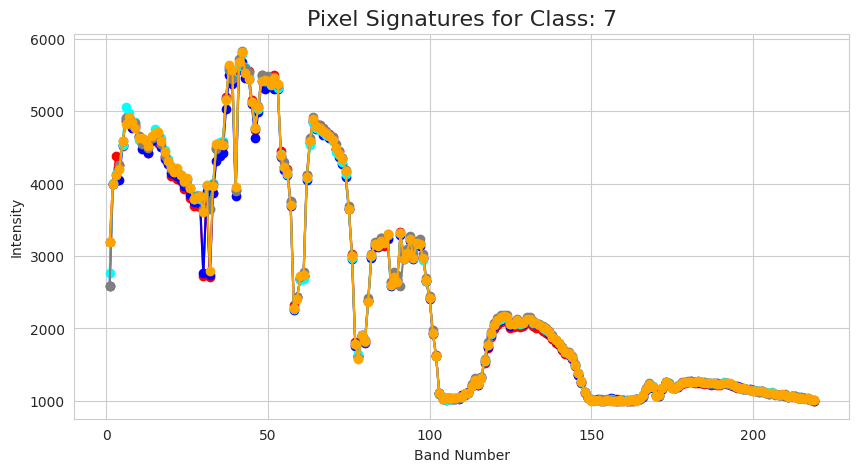

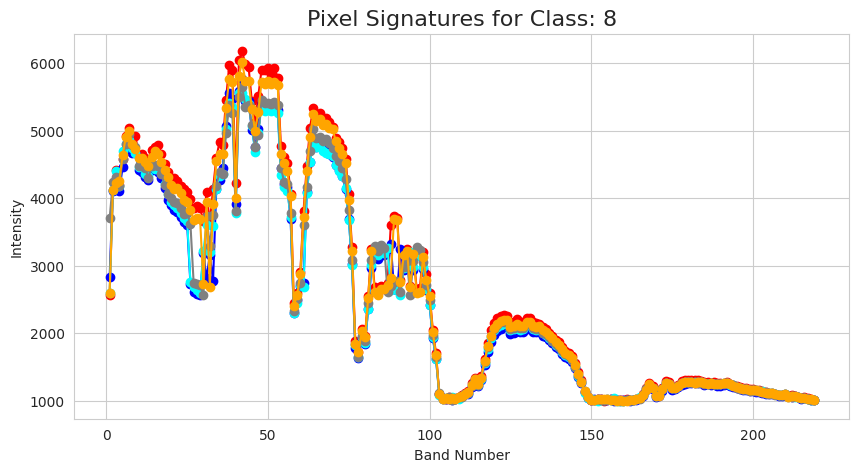

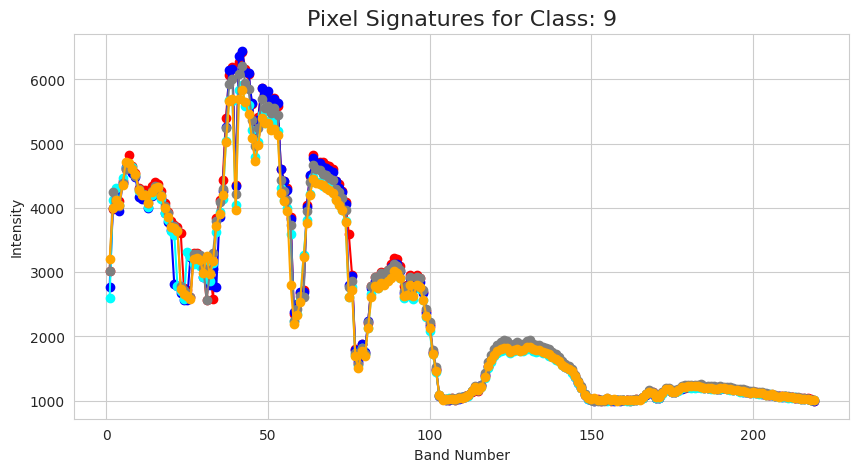

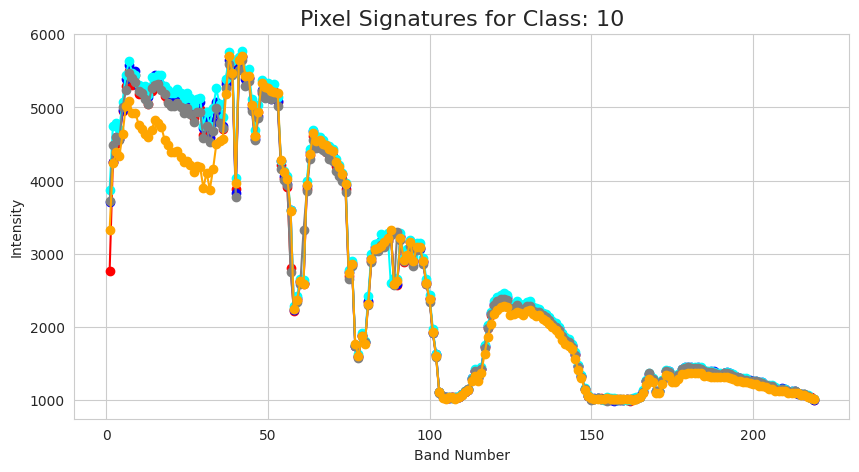

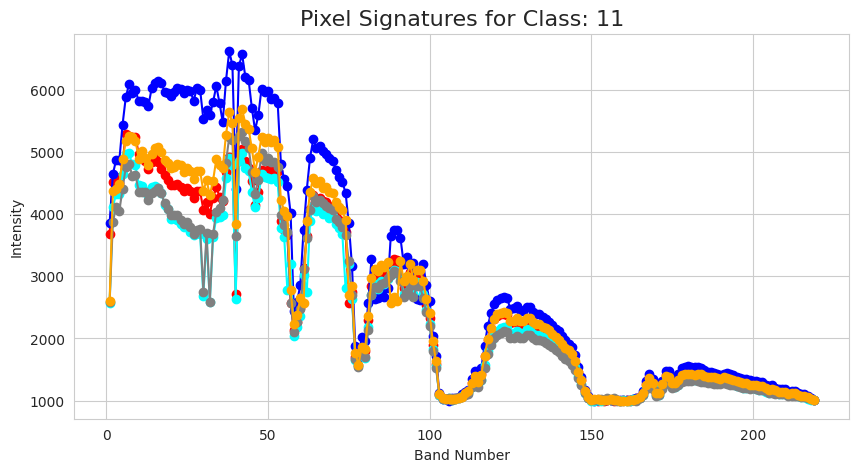

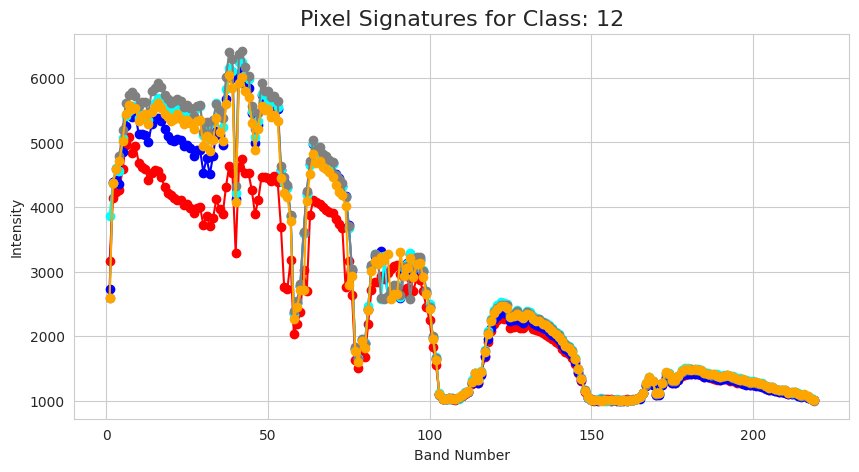

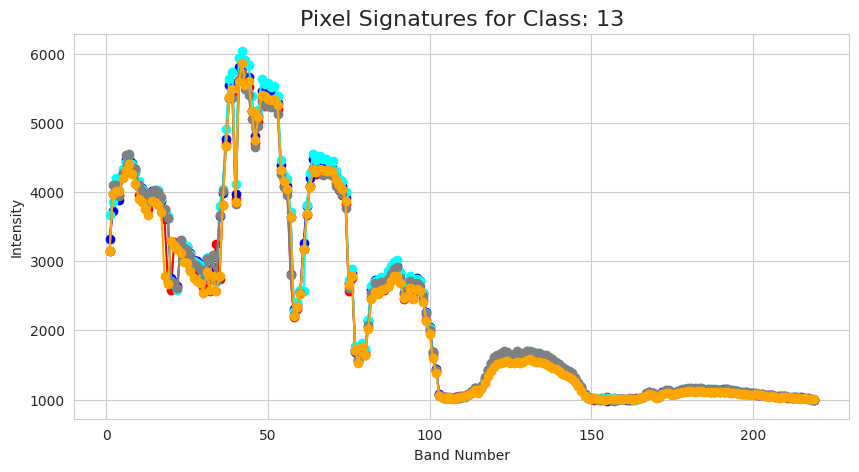

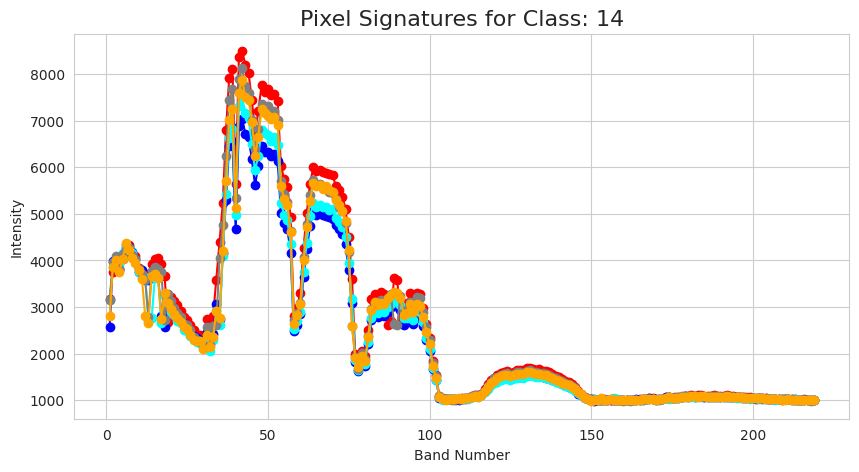

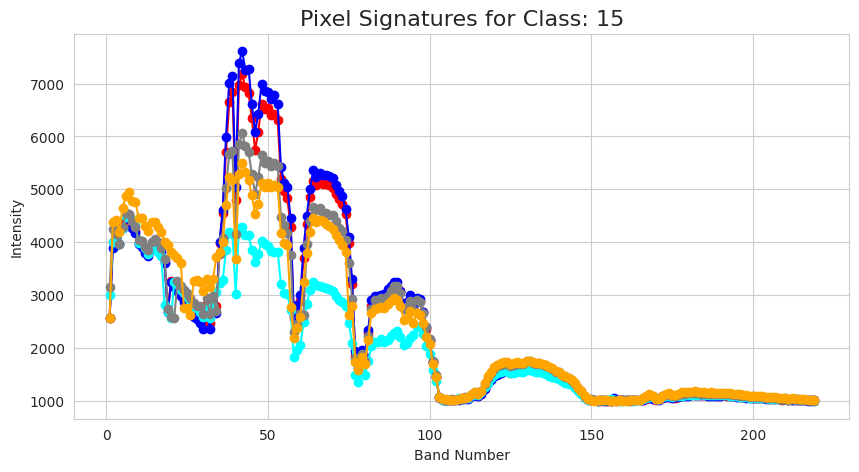

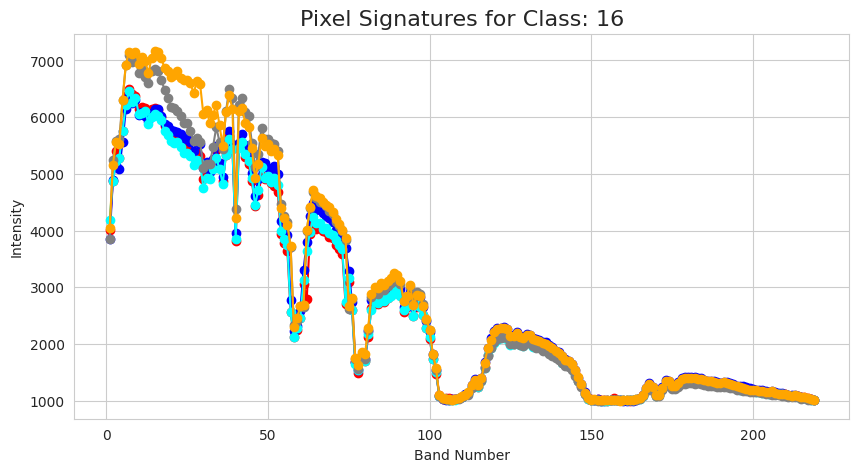

In [27]:
for i in range(1,17):
    pixel_signature_by_class(df, label=i)

### PCA

### **What is a Principal Component Analysis technique?**

Principal Component Analysis (PCA) is a method of dimensionality reduction that allows for simplifying the complexity of spaces with multiple dimensions while preserving their information.

Suppose there is a sample with 𝑛 individuals, each with 𝑝 variables (𝑋1, 𝑋2, ..., 𝑋𝑝), meaning the sample space has 𝑝 dimensions. PCA enables finding several underlying factors (𝑧<𝑝)
that explain approximately the same as the 𝑝 original variables. Whereas previously 𝑝 values were needed to characterize each individual, now only 𝑧 values are sufficient. Each of these 𝑧 new variables is called a principal component.

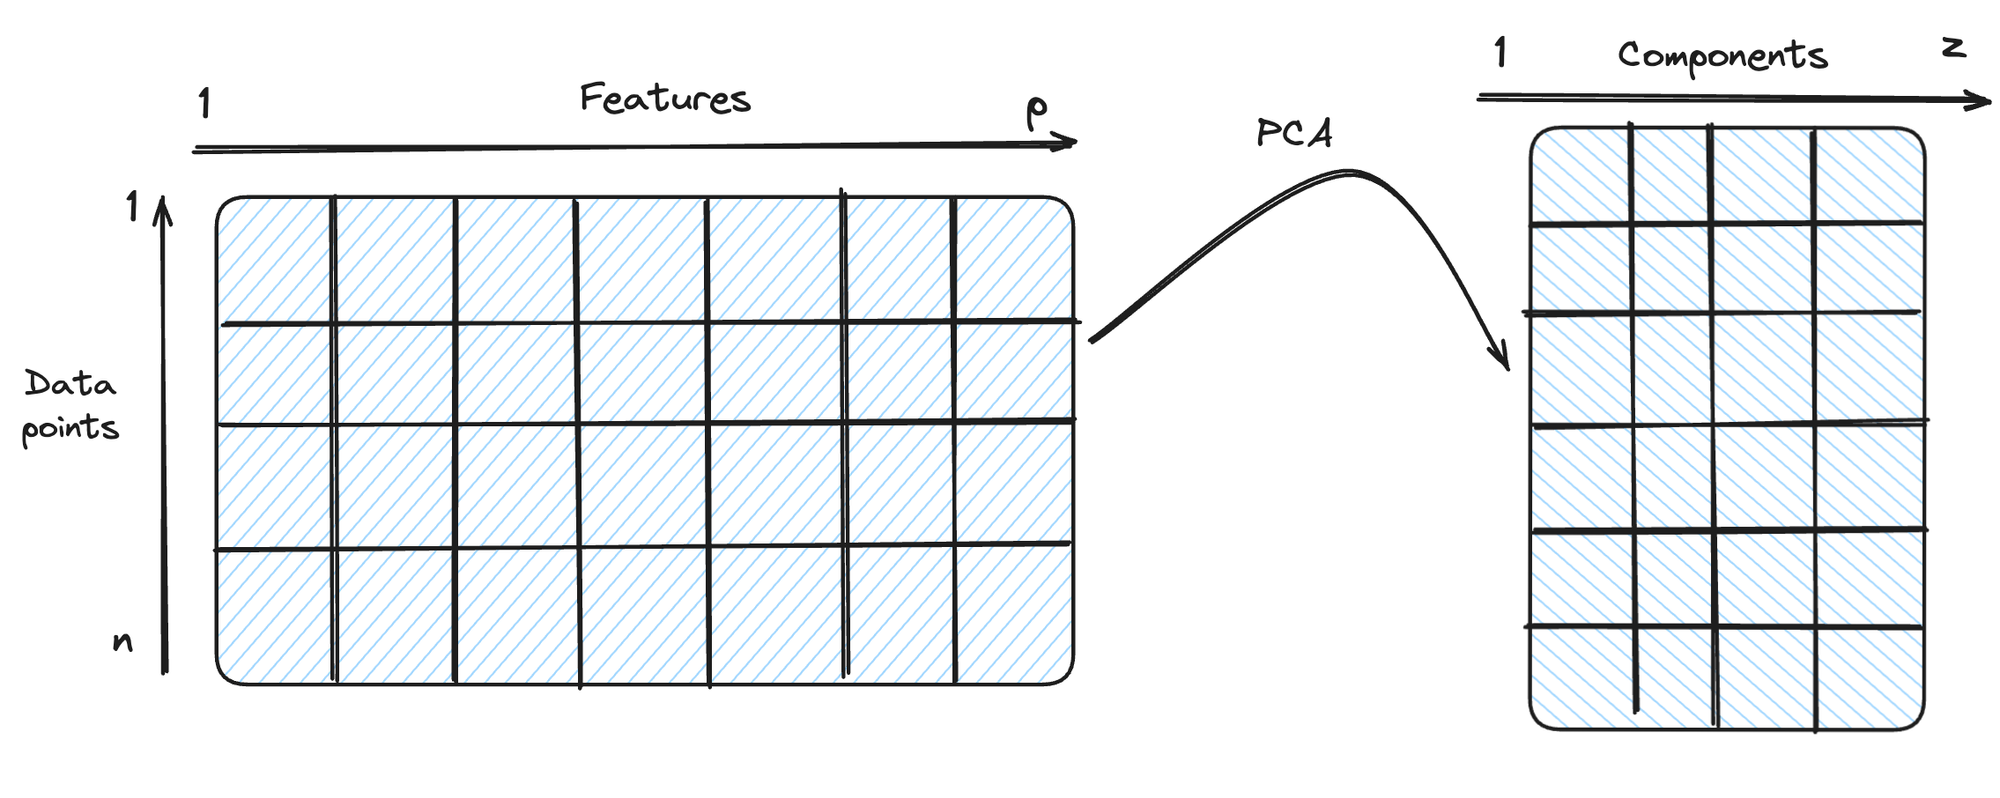

Therefore, the PCA method allows "condensing" the information provided by multiple variables into just a few components.  Each principal component (𝑍𝑖) is obtained by a linear combination of the original variables. They can be understood as new variables obtained by combining the original variables in a certain way. The first principal component of a group of variables (𝑋1, 𝑋2, ..., 𝑋𝑝) is the normalized linear combination of those variables that has the highest variance:

$$
Z_1=\phi_1X_1+\phi_2X_2+...+\phi_pX_p
$$

The terms 𝜙11, ..., 𝜙1𝑝 are referred to as loadings and they define the components. For instance, 𝜙11 is the loading of variable 𝑋1 in the first principal component. Loadings can be interpreted as the weight/importance that each variable has in each component, thus aiding in understanding the type of information each component captures.

In [92]:
df.describe()

band1         band2         band3         band4         band5  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    2957.363472   4091.321237   4277.502259   4169.956671   4516.678668   
std      354.918708    230.390005    257.827640    280.761254    346.035984   
min     2560.000000   2709.000000   3649.000000   2810.000000   3840.000000   
25%     2602.000000   3889.000000   4066.000000   3954.000000   4214.000000   
50%     2780.000000   4106.000000   4237.000000   4126.000000   4478.000000   
75%     3179.000000   4247.000000   4479.000000   4350.000000   4772.000000   
max     4536.000000   5744.000000   6361.000000   6362.000000   7153.000000   

              band6         band7         band8         band9        band10  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    4790.595149   4848.317574   4714.732509   4668.904828   4439.065541   
std      414.382138    469.247667    491.728349    533.232855    539.908195   
min     4056.000000   4004.000000   3865.000000   3775.000000   2792.000000   
25%     4425.000000   4421.000000   4263.000000   4173.000000   3940.000000   
50%     4754.000000   4808.000000   4666.000000   4632.000000   4404.000000   
75%     5093.000000   5198.000000   5100.000000   5084.000000   4860.000000   
max     7980.000000   8284.000000   8128.000000   8194.000000   7928.000000   

       ...       band212       band213       band214       band215  \
count  ...  21025.000000  21025.000000  21025.000000  21025.000000   
mean   ...   1060.210273   1063.276813   1050.048514   1040.201141   
std    ...     38.712195     41.920969     34.242725     26.452672   
min    ...    999.000000    999.000000    993.000000    990.000000   
25%    ...   1024.000000   1024.000000   1019.000000   1016.000000   
50%    ...   1052.000000   1054.000000   1043.000000   1033.000000   
75%    ...   1098.000000   1104.000000   1083.000000   1066.000000   
max    ...   1289.000000   1315.000000   1258.000000   1201.000000   

            band216       band217       band218       band219       band220  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    1043.370321   1030.194816   1015.571463   1008.513579   1006.791011   
std       29.794418     20.865106     11.386402      7.050921      6.995153   
min      992.000000    989.000000    986.000000    981.000000    980.000000   
25%     1016.000000   1012.000000   1006.000000   1004.000000   1003.000000   
50%     1035.000000   1026.000000   1014.000000   1009.000000   1005.000000   
75%     1072.000000   1050.000000   1024.000000   1014.000000   1010.000000   
max     1245.000000   1167.000000   1076.000000   1036.000000   1034.000000   

              class  
count  21025.000000  
mean       4.224923  
std        5.281972  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       10.000000  
max       16.000000  

[8 rows x 221 columns]

In [105]:
##Scaling the features

X = df.drop(['class'],axis=1)

scaler_ds = StandardScaler()

scaler = scaler_ds.fit(X.values)

features = scaler.transform(X.values)

df_x = pd.DataFrame(features, columns = X.columns)

df_x = X

##Run PCA

pca_model = PCA()

pca_model.fit(df_x.values)

PCA()

After training the PCA model, we analyzed the cumulative explained variance in relation to the number of principal components. This is a common approach to determine the optimal number of components to retain. We typically set a threshold for the explained variance (in this case, around 85%). As shown in the following plot, using 3 principal components captures approximately 83% of the variance:

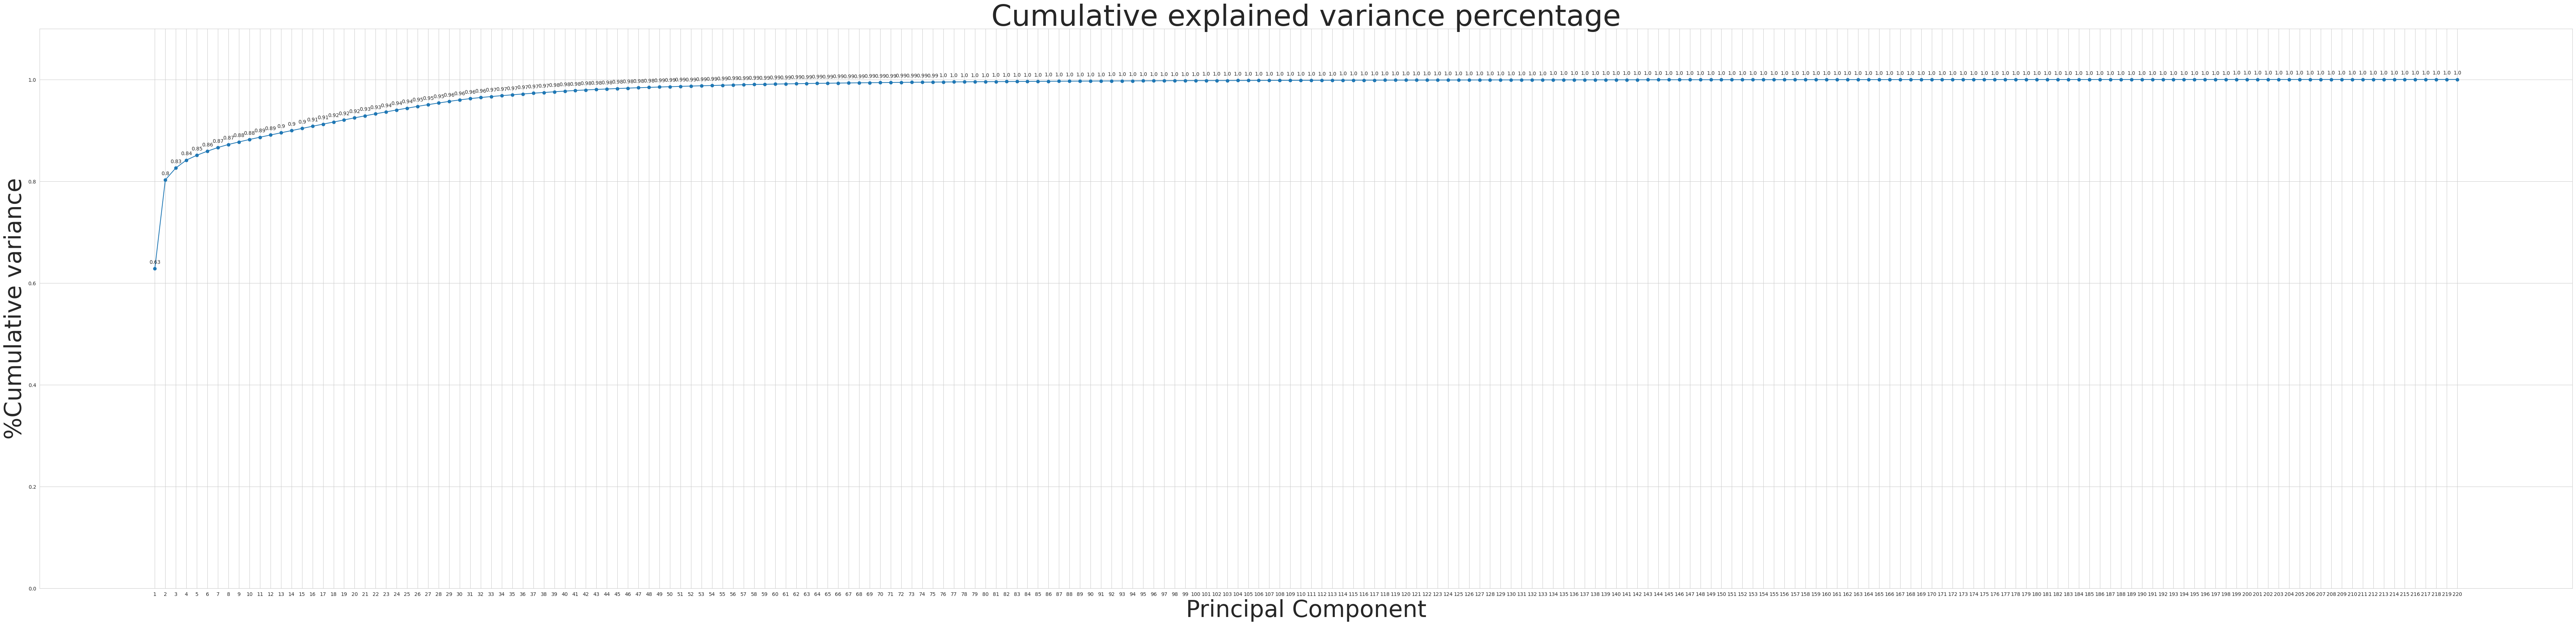

In [94]:
pca_cum_plot(pca_model, df_x, fig_size=(90, 20))

In [106]:
##Set the amount of components to 3

pca_model = PCA(n_components=3)

pca_model.fit(df_x.values)

features = pca_model.transform(df_x.values)

pca_features = pd.DataFrame(features) 


for var in pca_features.columns:
  pca_features = pca_features.rename(columns={var:'pca_'+str(var)})

##Adding the target

pca_features = pd.concat([pca_features, df['class']], axis=1)

#### Visualizing classes using PCA

In [96]:
pair = px.scatter_matrix(pca_features.sample(frac=0.3), dimensions=['pca_0', 'pca_1', 'pca_2',], color="class", 
            color_discrete_sequence= ["#1f77b4",   "#ff7f0e",  "#2ca02c",  "#d62728",   "#9467bd",   "#e04d71",   "#f7cac9",   "#c5b0d5",   "#59947f",  "#ce7e45",  "#8c5ba1",  "#de9ed6", "#e30052",  "#636363",  "#b7dbb8",  "#ff76b6"]
)

pair.update_layout(
    plot_bgcolor='white', )


pair.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [99]:
scatter_3d = px.scatter_3d(pca_features.sample(frac=0.15), x='pca_0', y='pca_1' , z='pca_2' , color="class", hover_name="class",symbol="class",
                          color_discrete_sequence= ["#1f77b4",   "#ff7f0e",  "#2ca02c",  "#d62728",   "#9467bd",   "#e04d71",   "#f7cac9",   "#c5b0d5",   "#59947f",  "#ce7e45",  "#8c5ba1",  "#de9ed6", "#e30052",  "#636363",  "#b7dbb8",  "#ff76b6"]
)

scatter_3d.show()


### **Silhouette Score:**

This metric can be used to study the separation distance between the resulting clusters, as a strategy for quantifying the quality of clustering. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters, and thus provides a way to assess parameters like the number of clusters visually.

Silhouette coefficient has a range of [-1, 1], it calculated by:

$$
s(i) =\frac{b(i)-a(i)}{max(a(i), b(i))}
$$

Where:

- a high value indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters.
- If most objects have a high value, then the clustering configuration is appropriate.
- If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
- A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
- Negative values indicate that those samples might have been assigned to the wrong cluster.

In [112]:
silhouette_score(df.drop(['class'], axis=1).values, df[['class']].values.flatten())

-0.26322198403456415